# Shor's Algorithm for the Factoring Problem

#### Elisabeth Llanos Pla - Quantum Computation. Assignment 2   
#### February 2023

This notebook presents the theoretical background of Shor's Algorithm for the Factoring Problem and an example and analysis for factoring the number N = 77. 

$\textbf{Table of contents:}$

1. Introduction


2. Period Finding using Quantum Phase Estimation - Theoretical approach

    2.1. Period of a function
    
    2.2. Quantum Phase Estimation
    
    2.3. Order-finding algorithm
    
    
3. Circuit implementation


4. Analysis

    4.1. Study on the effect of the size $t$ of the working register qubits
    
    4.2. Comparison on the effect of different choices of $a$
    
    
5. Considerations about the measurement requirements and computational cost

## 1. Introduction

In the cryptography field, RSA (Rivest-Shamir-Adleman) is a public key cryptographic system developed in 1979, based on the assumption that the factorization of large integer numbers is extremely hard to solve in a reasonable amout of time using classical computation. Up to date, no classical algorithm is known to be able to decompose a large number into a product of primes in polynomial time; nevertheless, if this would happen, RSA wouldn't be secure anymore. In 1994, Peter Shor concieved a quantum computer algorithm that has proven to enable the factorization of numbers in polynomial time, and thus defeating the RSA system: the Shor's algorithm.

Next, we give a brief explanation of the functioning of the algorithm, which comprises both a classical and a quantum part. It is important to mention that this algorithm only works for odd numbers. If the number N we want to factorize is even, we get the number 2 as a trivial factor and we stop the algorithm.

 
   1. If $N$ is even, number 2 is a trivial factor of N $\checkmark$
   
   
   2. Pick a random number $1<a<N$  
                                 
                                 
   3. Compute $C = gcd(a,N)$ (great common divisor)  
                                 
        * If $C \neq$ 1 $\longrightarrow C$ is a non-trivial factor of $N$  $\checkmark$
                                 
        * If $C = 1 \longrightarrow$ Use the quantum period-finding subroutine in order to find the period $r$ of the function $f(k) = a^k (mod N)$
    
         $\hspace{0.5cm}$ - If $r$ is odd or $a^{r/2} = -1 mod N$, re-start the process (go back to step 1)
    
         $\hspace{0.5cm}$ - Otherwise, $gcd(a^{r/2}+1, N)$ and $gcd(a^{r/2}-1, N)$ are non-trivial factors of N $\checkmark$
                                          

## 2. Period Finding using Quantum Phase Estimation - Theoretical approach

Now that we have the main structure of the Shor's algorithm, we will focus on its quantum part: the period-finding algorithm, also called order-finding. This algorithm enables to factor integers in polynomial time with the number $N$ we want to factorize. It has been proven that, if we can compute the period of this function efficiently, we can also factorize $N$ in the same way. 

### 2.1. Period of a function

The factoring task can be translated into the problem of computing the period $r$ of the following periodic function:

$\hspace{3cm} f(k) = a^k \mod N $

The period of this function is the smallest positive integer that satisfies $a^r \equiv 1 (mod N)$, where the modulo (mod) operation stands for finding the remainder of the division of two numbers. 

Let's see how to interpret this period. We can define an operator $U$ such that:
   
$\hspace{3cm} U|y\rangle = |ay \mod N\rangle $
 

We can see an example for $a=3$ and $N=77$, starting with the state $|1\rangle$ for simplicity.

  
$\hspace{3cm} U|1\rangle = |3 \cdot 1 \mod 77\rangle = |3\rangle $   

$\hspace{3cm} U^2|1\rangle = U|3\rangle = |3 \cdot 3 \mod 77\rangle = |9\rangle$

$\hspace{3cm} U^3|1\rangle = U|9\rangle = |3 \cdot 9 \mod 77\rangle = |27\rangle$

$\hspace{3cm} U^4|1\rangle = U|27\rangle = |3 \cdot 27 \mod 77\rangle = |4\rangle $

$\hspace{3cm}$ .

$\hspace{3cm}$ .

$\hspace{3cm} U^{30}|1\rangle = U|26\rangle = |3 \cdot 26 \mod 77\rangle = |1\rangle $

 
We see that we obtain the initial state $|1\rangle$ after applying the $U$ operator a total number of $r=30$ times on the initial state, meaning that this is the period of our function $f(k)$. 
 
We can see the period graphically:


Period r =  30


Text(0, 0.5, 'End state after multiple applications of U')

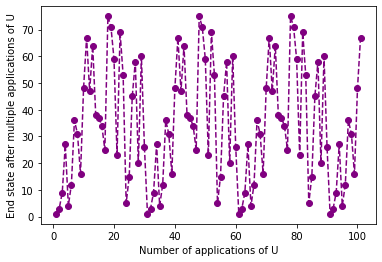

In [771]:
import pylab as pl

a = 3 # random number that we pick
N = 77 # number that we want to factorize
initial_state = 1 # initial state
n = 1 # counts how many times we apply the operator on the initial state (initialized to 1)
previous_state = initial_state # variable initialized to the initial state
actual_state = 0 # variable initialized to 0
vector_n = [1] # vector where we will store the different m values
vector_state = [initial_state] # vector where we will store the different states for each m value
count = 1 # counter

# We define a function that computes the resulting state 
# after applying the operator U, m times on the initial state
def operator_U(previous_state):
    state = (a*previous_state) % N
    return state

# For an arbitrary number (m=30) of iterations, we apply m times the operator U on the initial state
for i in range(100):
    actual_state = operator_U(previous_state)
    if (count == 1 and actual_state == 1):
        print ("Period r = ", n)
        count+=1
    n+=1
    vector_n.append(n)
    vector_state.append(actual_state)
    previous_state = actual_state  

pl.plot(vector_n, vector_state, marker='o', linestyle='dashed', color='purple')
pl.xlabel('Number of applications of U')
pl.ylabel('End state after multiple applications of U')


### 2.2. Quantum Phase estimation

We are interested in extracting this period in order to obtain the non-trivial factors of N by computing $gcd(a^{r/2}+1, N)$ and $gcd(a^{r/2}-1, N)$. To extract the period, we will use the Quantum Phase Estimation (QPE) algorithm.

Let's consider the case in which we have a qubit in state $|0\rangle + |1\rangle$ and another qubit in state $|u\rangle$, so the total state of the system is defined as 

$\hspace{3cm} |\Psi\rangle = (|0\rangle + |1\rangle)\otimes|u\rangle$ 

Next we define an operator such that: $U|u\rangle = e^{2\pi i  \phi}|u\rangle$ where the phase is related with the period by the expression: $\phi = \frac{s}{r}$.

QPE consists in applying the $U$ operator on $|u\rangle$ controlled by $(|0\rangle + |1\rangle)$, obtaining:


$\hspace{3cm} U|\Psi\rangle = |0\rangle \otimes |u\rangle + |1\rangle \otimes e^{2i\pi\phi}|u\rangle  = (|0\rangle + e^{2i\pi\phi}|1\rangle)\otimes |u\rangle $


Where the phase $\phi$ has been reallocated to the first qubit. 

Imagine we have $t$ qubits on the first register ($|0\rangle + |1\rangle$). After applying all powers of the $U^j$ operator, we obtain:

$\hspace{3cm} |\tilde{\Psi}\rangle = \frac{1}{\sqrt{2^t}}(|0\rangle + e^{2i\pi2^{t-1}}|1\rangle)\otimes(|0\rangle + e^{2i\pi2^{t-2}}|1\rangle)\otimes...\otimes(|0\rangle + e^{2i\pi2^{0}}|1\rangle)\otimes|u\rangle$

where j $\in [0, 2^{t-1}]$. The first term stands for the application of $U^j$ on the first qubit, the second term stands for the application on the second qubit, an so on. 

Before continuing with this procedure, we should introduce the Quantum Fourier Transform:

#### Quantum Fourier Transform (QFT)

The QFT applied on a $q$ qubit state, expressed in an
orthonormal basis $|0\rangle, ..., |N − 1\rangle$ can be written as:

$\hspace{3cm} |j_1j_2...j_n\rangle \longrightarrow \frac{1}{\sqrt{N}}\sum^{N-1}_{k=0}e^{2\pi i j k /N}|k_1k_2...k_n\rangle$

where $N = 2^q$. 

Using the binary representation of an integer: $j = j_1j_2...j_n = j_12^{n-1}+j_22^{n-2}+...+j_n2^0 = \sum_l j_l \cdot 2^{n-l}$

and the binary representation of a fraction: $0.j_1j_2...j_n = j_12^{-1} + j_22^{-2} + ... + j_n2^{-n}$

we can express the QFT as:

$\hspace{3cm} \frac{1}{\sqrt{2^n}}(|0\rangle + e^{2\pi i 0.j_n}|1\rangle)\otimes(|0\rangle + e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\otimes...\otimes(|0\rangle + e^{2\pi i 0.j_1j_2...j_n})$



Going back to the expression of $|\tilde{\Psi}\rangle$, using the binary representation of a fraction we can re-writte:

$\hspace{3cm} |\tilde{\Psi}\rangle = \frac{1}{\sqrt{2^t}}(|0\rangle + e^{2i\pi0.\phi_j}|1\rangle)\otimes(|0\rangle + e^{2i\pi0.\phi_{j-1}\phi_j}|1\rangle)\otimes...\otimes(|0\rangle + e^{2i\pi0.\phi_1\phi_1...\phi_j}|1\rangle)\otimes|u\rangle = \frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^t-1}e^{2\pi i \phi k}|k\rangle \otimes |u\rangle $

We can see that this expression has de structure of a Quantum Fourier transform; therefore, if we apply the inverse Quantum Fourier transform, we will obtain the state $|2^t\phi\rangle\otimes|u\rangle$. Therefore, when we then measure the first register qubits, we will be able to extract the phase $\phi$, and recover the period $r$. 

### 2.3. Order-finding algorithm

The quantum algorithm for order-finding is just the phase estimation algorithm applied to the unitary operator:  $ U|y\rangle = |ay \mod N\rangle $, where we can define $|y\rangle$ as a superposition of the states that comprise the cycle described by $U|y\rangle$. This superposition is an eigenstate of the operator $U$, and we can choose this eigenstate to have a different phase for each of the states of the cycle. We can write this eigenstate as:


$\hspace{3cm} |u_s\rangle = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{\frac{-2 \pi i s k}{r}}|a^k \mod N\rangle $

Where we have added the parameter $s$ on the phase factor to make the state even more general. Moreover:

$\hspace{3cm} \frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}|u_s\rangle = |1\rangle$

since $\sum_{s=0}^{r-1}e^{-2\pi i s k /r} = r\delta_{k0}$, so all the other terms cancel each other becaue of the phases.

We can apply the operator on this new state, and we obtain:

$\hspace{3cm} U|u_s\rangle = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{\frac{-2 \pi i s k}{r}}|a^{k+1} \mod N\rangle = e^{\frac{2 \pi i s}{r}}|u_s\rangle$

Thus, if we use $|1\rangle = \sum_s|u_s\rangle$ as the second register qubit, we will obtain the state:

$\hspace{3cm} \frac{1}{\sqrt{r}\sqrt{2^t}}\sum_{k}|k\rangle \sum_s U|u_s\rangle = \frac{1}{\sqrt{r}\sqrt{2^t}}\sum_k|k\rangle\sum_se^{\frac{2\pi i s}{r}}|u_s\rangle $

Then, by performing the inverse Fourier Transform as we previously explained, we obtain  the state:

$\hspace{3cm} \frac{1}{\sqrt{r}}\sum_s|2^t\frac{s}{r}\rangle\otimes|u_s\rangle$

And by measuring the first register qubits, we can recover the phase $\phi=\frac{s}{r}$

## 3. Circuit implementation

For the circuit implementation we need two differenciated set of qubits: a number $t$ of "register qubits", all set to $|0\rangle$, and a second collection of qubits $m$ set to $\sum_s|u_s\rangle$. We have previously proven that: $\sum_s|u_s\rangle = |1\rangle$; therefore the second collection of qubits can be set to $|1\rangle$. Using the code below, we import the necessary libraries and modules, and we define the number of qubits of our circuit, the number $N$ we want to factorize, and the initial number $a$ we pick:

In [772]:
import numpy as np
from qiskit import QuantumCircuit
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from fractions import Fraction
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [791]:
a = 3
N = 77
t = 5  #number of quibits of the working register (first qubit register)
m = 7  #number of additional qubits (second qubit register)
n_q = m +t  #total number of qubits: t+m

To do the factorization, we perform Quantum Phase Estimation following the procedure:

$\textbf{1. Initial state}$  

The initial state is then: $|\Psi_0\rangle = |0\rangle^{\otimes t}|1\rangle^{\otimes m}$

$\textbf{2. Apply Hadamard gates on the first register qubits}$

The first thing we need to do is to apply a Hadamard gate (H) to the $t$ register qubits, and we obtain the following superposition:

$\hspace{3cm} |\Psi_1\rangle = \frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^{t-1}}|k\rangle|1\rangle^{\otimes m}$


$\textbf{3. Apply the U operator on the second collection of qubits}$

After applying the Hadamard gate to the register qubits we apply the controlled $U$ operator on the second collection of $m$ qubits. Each $U^k$ ($k \in [0,2^{t-1}]$) is acting on a target qubit $|1\rangle$, and has a corresponding control qubit from the first register. This operator acts as:

$\hspace{3cm} U|y\rangle = |ay \mod N\rangle$

We apply all the other powers of the controlled U to obtain a superposition of the possible values of $f(k)$, that is, a state containing all the possible values that are comprised in one period:

$\hspace{3cm} |\Psi_2\rangle = U|\Psi_1\rangle = \frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^{t-1}}|k\rangle |a^k \mod N\rangle = \frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^{t-1}}|k\rangle |f(k)\rangle $

$\underline{Example}$:  For $a=3$ and $N=77$, we have:

In [792]:
# state 2 example

vector_state = []
vector_k = []

for k in range(2**(n_q - 1)):
    vector_k.append(k)
    vector_state.append((a**k) % N)

print("|",vector_k[0], "> |",vector_state[0], "> +" ,
"|",vector_k[1], "> |",vector_state[1], "> +" ,
"|",vector_k[2], "> |",vector_state[2], "> +" ,
"|",vector_k[3], "> |",vector_state[3], "> +",
"|",vector_k[4], "> |",vector_state[4], "> +...")
    

| 0 > | 1 > + | 1 > | 3 > + | 2 > | 9 > + | 3 > | 27 > + | 4 > | 4 > +...


To obtain $|\Psi_2\rangle$, we can directly prepare the Quantum state. To do so, we can use the $\textit{get_coeffs()}$ function. This function computes $U|y\rangle = |ay \mod N\rangle$ where $|y\rangle = 1$, and we apply the $U$ operator $i$ times. 

This function gets as arguments:

* a: the initial number we pick to start the factorization

* N: the integer number we want to factorize

* n_q: the total number of qubits

* n_count: the number of register qubits

And it returns:

* A vector of $2^{n\_q}$ positions containing a "1" in the positions corresponding to the integer value of $f(k) + k$ (which are represented in binary strings), for each $k$ value.

Observing the last example, we can see that for the first state $|0\rangle |1\rangle$:

$\hspace{3cm} |0\rangle \longrightarrow$ binary string representation (n_count bits): 0000

$\hspace{3cm} |1\rangle \longrightarrow$ binary string representation (n_q - n_count bits): 000001

So the first "1" in the returned vector will be in position 0000010000 = 16.


In [793]:
def get_coeffs(a, N, n_q, n_count):
    vec = np.zeros(2**n_q) # set all the vector positions to 0
    base = 1
    for i in range(2**n_count): 
        s1 = np.binary_repr(i,n_count) # binary representation of number i, using n_count bits
        mod2 = np.mod(base,N) # result of the operation (base mod N)
        base = mod2*a 
        s2 = np.binary_repr(mod2,n_q-n_count) #binary representation of mod2 using n_q - n_count bits
        vec[int(s2+s1,2)] = 1 # sets to 1 the coefficient corresponding to s2+s1 in decimal base
    return vec

vec = get_coeffs(a, N, n_q, t)
vec = np.multiply(vec, 1/np.sqrt(2**t)) # we multiply by the 1/(2^(t/2)) factor


An alternative to obtain $|\Psi_2\rangle$ is to implement the circuit following the previous mentioned steps: first apply a Hadamard gate to the register qubits, and then de U operator. 

The code below has been extracted from the $\textit{Qiskit}$ webpage, and slightly tuned.

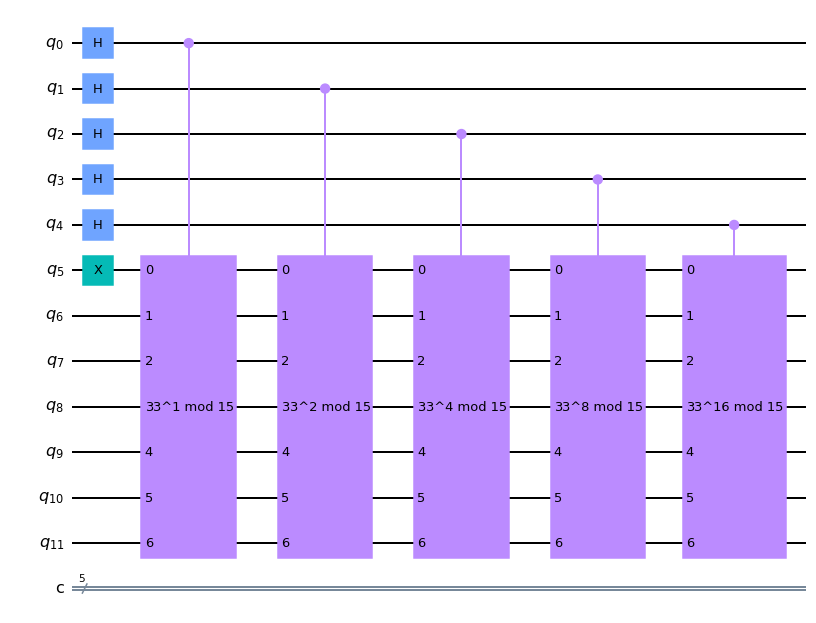

In [794]:
# Create QuantumCircuit with n_count counting qubits
qc = QuantumCircuit(n_q, t)

# Apply Hadamard gates to the register qubits, itialized to |0>
for q in range(t):
    qc.h(q)
    
# Initialize the auxiliary register in state |1>
qc.x(t)

# a mod N operation on the second register qubits, controlled on the first register qubits
def c_amod15(a, q):
    U = QuantumCircuit(n_q-t) 
    
    for iteration in range(2**q):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for i in range(n_q-t):
                U.x(i)
    
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, 2**q)
    c_U = U.control()
    return c_U

# Apply the controlled-U operator
for q in range(t):
    qc.append(c_amod15(a, q), 
             [q] + [i+t for i in range(n_q - t)])

qc.draw('mpl',fold=-1)  # -1 means 'do not fold'

$\textbf{4. Apply the inverse Quantum Fourier Transform on the first register qubits}$

As we previously explained, the resulting state $|\Psi_2\rangle$ (obtained after applying the Hadamard gates on the register qubits and the $U$ operator on the second collection of qubits) has the structure of a Quantum Fourier Transform. Therefore, to estimate the phase $\phi$ we need to invert the Quantum Fourier Transform by applying an inverse Quantum Fourier Transform ($QFT^{\dagger}$). By doing this transformation, we will obtain a superposition of states with phases $\phi_s$ for 0 ≤ s ≤ r − 1.

The circuit implementation of a Quantum Fourier Transform for $n$ qubits consists in applying to each qubit a Hadamard gate followed by rotation gates. For the qubit number $a$ we will apply $n-a$ rotation gates, each of these defined as:

$\hspace{3cm}    R_k =
    \begin{bmatrix}
    1 & 0 \\
    0 & e^{\frac{2\pi i}{2^k}}
    \end{bmatrix} $

We can check that this procedure gives a final state:

$\hspace{3cm} \frac{1}{\sqrt{2^n}}(|0\rangle + e^{2\pi i 0.j_1j_2...j_n})\otimes...\otimes(|0\rangle + e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\otimes(|0\rangle + e^{2\pi i 0.j_n}|1\rangle) $

We can see that this state has the format of the Quantum Fourier transform previously written: 

$\hspace{3cm} \frac{1}{\sqrt{2^n}}(|0\rangle + e^{2\pi i 0.j_n}|1\rangle)\otimes(|0\rangle + e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\otimes...\otimes(|0\rangle + e^{2\pi i 0.j_1j_2...j_n})$

With the difference that the qubit 1 and N, 2 and N-1,... are swapped. Therefore, to obtain a QFT we need to apply swap gates.

For implementing the inverse Quantum Fourier Transform, we have to follow the described procedure in the inverse order: we will first need to swap the position of the qubits (permuting qubit number $a$ with qubit number $n-a$), and then apply first the rotations and finally the Hadamard gates to each qubit. Below we can see the code corresponding to the implementation of $QFT^{\dagger}$.

In [779]:
# this function performs the Inverse Quantum Fourier Transform on the first n qubits of the register

def qft_dagger(n):
    qc = QuantumCircuit(n) # definition of the quantum circuit for n qubits
    
    # we swap the qubit number "a" for the qubit number "n-a"
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    
    # for each of the qubits on the register, and for each state of the superposition in a qubit
    for j in range(n):
        for m in range(j):
            # we apply the controlled phase gate (a rotation R_(j-m)) 
            # to the target qubit j, being m the control qubit
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        # we apply a Hadamard gate
        qc.h(j)
    qc.name = "QFT†"
    return qc

$\textbf{5. Initialize and run the quantum circuit and perform a counting of the results}$

Once we have build all the necessary functions, we can initialize the quantum circuit and perform the measurements on the register qubits:

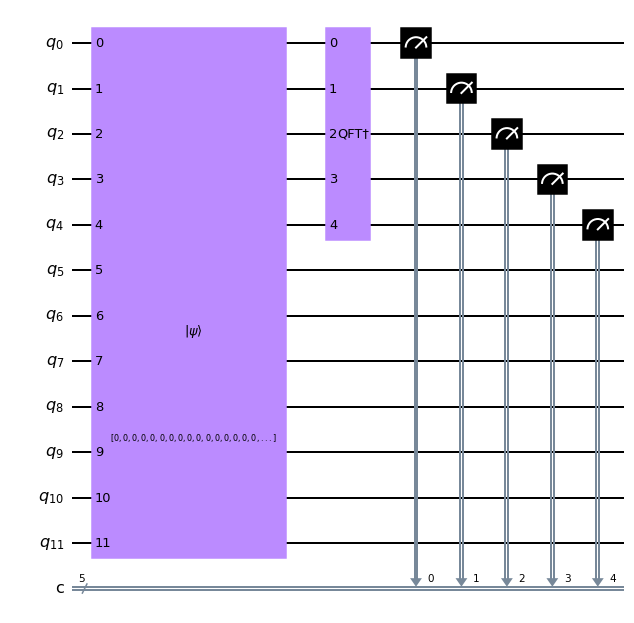

In [795]:
Q = QuantumCircuit(n_q,t)
Q.initialize(vec)
Q.append(qft_dagger(t),range(t))
Q.measure(range(t),range(t))
Q.draw('mpl',fold=-1)  

Finally, we run the circuit many times in order to see the performance and results of the quantum phase estimation algorithm. IBM offers some quantum computers to be run via cloud, and we can set the number of shots to 10000 to have more statistics. The following basic operation runs a quantum circuit and returns a "counts" dictionary of measurement outcomes.

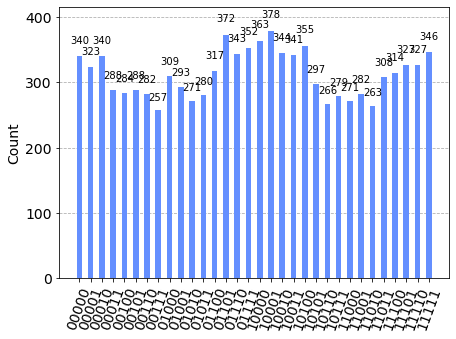

In [796]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(Q, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj, shots=10000).result()
counts = results.get_counts()
#print(counts)
plot_histogram(counts)

The output histogram shows the number of times that the measured register qubits were in each of the possible combinations.

$\textbf{6. Compute the continuous fraction}$

As we explained in the theoretical approach section, the state we obtain after applying the Quantum Phase Estimation can be written as:

$\hspace{3cm} |\Psi_3\rangle = \frac{1}{\sqrt{r}}\sum_s|2^t\frac{s}{r}\rangle |u_s\rangle
 \hspace{1cm}$
where $\phi=\frac{s}{r}$ is the phase for each $s$ value.

Since we are measuring the first register qubits, for each shot we are obtaining one of the possible states $|2^t\frac{s}{r}\rangle$, codified in binary. We can first convert $2^t\frac{s}{r}$ to decimal base, and next divide by $2^t$ in order to recover the phase.

Moreover, we can express the phase as a fraction between $s$ and the period $r$ of the function $f(k)$. To do so we use the $\textit{Fraction.limit_denominator}$ method, which is used to restrict the denominator value to a value that is less than or equal to the specified value ($N$ in this case). This way, we are extracting the period $r$, that ideally should appear in the denominator of this fraction. Finally, we compute the following expressions:

$\hspace{3cm} gcd(a^{r/2}+1, N) \hspace{2cm} gcd(a^{r/2}-1, N)$

Which will be the non-trivial factors of $N$ that we were looking for.

Here we run an example for $N = 77$, whose factors are 7 and 11, and we display the important parameters and guesses in a pandas table format. As we are using a small number of qubits on the working register, we will only get trivial factors. See section 4 for a detailed explanation and more examples.

In [798]:
probability = 0.
rows, measured_phases = [], []
print(counts)

vect_factors=[]

for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal base
    phase = decimal/(2**t)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])

# Print the rows in a table
print("")
headers=["Register Output", "Fraction", "Guess for r", "guess1","guess2"]
df = pd.DataFrame(rows, columns=headers)
print(df)


{'01000': 309, '00011': 288, '00100': 284, '01010': 271, '00000': 340, '00101': 288, '10101': 297, '10011': 341, '01110': 343, '00111': 257, '10100': 355, '01111': 352, '10111': 279, '01101': 372, '01011': 280, '00001': 323, '11010': 263, '11100': 314, '11000': 271, '01100': 317, '11110': 327, '10010': 344, '00010': 340, '11001': 282, '10000': 363, '01001': 293, '11011': 308, '11111': 346, '11101': 327, '00110': 282, '10110': 266, '10001': 378}

          Register Output Fraction  Guess for r  guess1  guess2
0   01000(bin) =   8(dec)      1/4            4       1       1
1   00011(bin) =   3(dec)     3/32           32       1       1
2   00100(bin) =   4(dec)      1/8            8       1       1
3   01010(bin) =  10(dec)     5/16           16       1       1
4   00000(bin) =   0(dec)      0/1            1      77       1
5   00101(bin) =   5(dec)     5/32           32       1       1
6   10101(bin) =  21(dec)    21/32           32       1       1
7   10011(bin) =  19(dec)    19/32    

## 4. Analysis

 ### 4.1. Study on the effect of the size $t$ of the working register

Once we know how everything works, we can analyse the effect of the size $t$ of the working register qubits. To do so, we can repeat the same experiment fixing $N = 77$ and $a = 5$, but changing the value of $t$. To represent the number $N = 77$ we need $log_2(N) \approx 7$ qubits; therefore the size of the second qubit register will be fixed to m = 7. We will perform the experiments for different values of $t$ from 1 to 15.

In the code below we define a function that computes the probability of success of our algorithm, by counting the times that we obtain each combination of guesses. We analyse for which $t$ values the probability of success (finding both desired factors 7 and 11) is higher.

In [721]:
def get_probabilities(a,N,t,n_q, test):

    rows, measured_phases = [], []
    probability = 0
    prob_factors=[0,0,0,0,0] #1-1, 1-7, 1-11, 7-11, 1-77
    
    vec = get_coeffs(a, N, n_q, t)
    vec = np.multiply(vec, 1/np.sqrt(2**t))

    Q = QuantumCircuit(n_q,t)
    Q.initialize(vec)
    Q.append(qft_dagger(t),range(t))
    Q.measure(range(t),range(t))
    Q.draw('mpl',fold=-1)  # -1 means 'do not fold'

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(Q, aer_sim)
    qobj = assemble(t_qc)
    results = aer_sim.run(qobj, shots = 10000).result()
    counts = results.get_counts()
    plot_histogram(counts)

    for output in counts:
        decimal = int(output, 2)  
        phase = decimal/(2**t) 
        measured_phases.append(phase)
        frac = Fraction(phase).limit_denominator(N)

        factor1 = np.gcd(a**(frac.denominator//2)-1, N)
        factor2 = np.gcd(a**(frac.denominator//2)+1, N)
        
        '''if(test == 0):
            if ((factor1 == 5 and factor2 == 7) or (factor1 == 7 and factor2 == 5)):
                probability += counts[output]/10000.'''
        
        if (test == 1):
            if((factor1 == 1 and factor2 == 1) or (factor1 == 1 and factor2 == 1)):
                prob_factors[0] += counts[output]/10000.
            if((factor1 == 1 and factor2 == 7) or (factor1 == 7 and factor2 == 1)):
                prob_factors[1] += counts[output]/10000.
            if((factor1 == 1 and factor2 == 11) or (factor1 == 11 and factor2 == 1)):
                prob_factors[2] += counts[output]/10000.
            if((factor1 == 7 and factor2 == 11) or (factor1 == 11 and factor2 == 7)):
                prob_factors[3] += counts[output]/10000.
            if((factor1 == 1 and factor2 == 77) or (factor1 == 77 and factor2 == 1)):
                prob_factors[4] += counts[output]/10000.

        if (test == 0):
            '''i=0
            for guess_factor in vect_guess_factor:
                if (factor1 == guess_factor or factor2 == guess_factor):
                    if (factor1 == guess_factor and factor2 == guess_factor):
                        prob_factors[i] += 2.*counts[output]/20000.
                    else:
                        prob_factors[i] += counts[output]/20000.
                i+=1'''
            if ((factor1 == 7 and factor2 == 11) or (factor1 == 11 and factor2 == 7)):
                probability += counts[output]/10000.
                
        if (test == 2):
            if ((factor1 == 7 and factor2 == 11) or (factor1 == 11 and factor2 == 7)):
                probability += counts[output]/10000.
            if ((factor1 == 1 and factor2 == 7) or (factor1 == 7 and factor2 == 1)):
                probability += counts[output]/10000.
            if ((factor1 == 1 and factor2 == 11) or (factor1 == 11 and factor2 == 1)):
                probability += counts[output]/10000.
                    
    if (test == 0 or test == 2):
        return probability
    if (test == 1):
        return prob_factors


In [717]:
a = 5
N = 77
m = int(np.ceil(np.log2(N))) 
vector_t = [2,5,8,10,11,13,15]

We create a bar chart displaying the probability of finding each possible combination of factors: 1-1, 1-7, 1-11, 7-11 and 1-77 as resulting factor guesses of the Shor's algorithm, for each size $t$ of the working register qubits. 

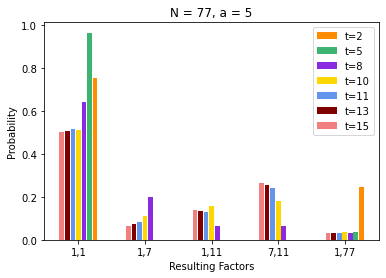

In [714]:
test = 1

vector_prob = []
for t in vector_t:
    n_q = m + t
    prob = get_probabilities(a,N,t,n_q,test)
    vector_prob.append(prob)

X = ['1,1','1,7','1,11','7,11','1,77']
t2, t5, t8, t10, t11, t13, t15 = vector_prob[0], vector_prob[1], vector_prob[2], vector_prob[3], vector_prob[4], vector_prob[5], vector_prob[6]

X_axis = np.arange(len(X))

width_hist = np.linspace(-0.25,0.25,7)
width_bar = 0.5/7.
      
plt.bar(X_axis - width_hist[0], t2, width_bar, label = 't=2', color = "darkorange")
plt.bar(X_axis - width_hist[1], t5, width_bar, label = 't=5', color = "mediumseagreen")
plt.bar(X_axis - width_hist[2], t8, width_bar, label = 't=8', color = "blueviolet")
plt.bar(X_axis - width_hist[3], t10, width_bar, label = 't=10', color = "gold" )
plt.bar(X_axis - width_hist[4], t11, width_bar, label = 't=11', color = "cornflowerblue")
plt.bar(X_axis - width_hist[5], t13, width_bar, label = 't=13', color = "maroon")
plt.bar(X_axis - width_hist[6], t15, width_bar, label = 't=15', color = "lightcoral")

plt.xticks(X_axis, X)
plt.xlabel("Resulting Factors")
plt.ylabel("Probability")
plt.title("N = 77, a = 5")
plt.legend()
plt.show()

Analysing this results, we can see that the trivial factors 1 and 77 are found for all the studied $t$ values. However, as we can see in the plot, the non-trivial factors 7 and 11 are not a solution when using a small working qubit register ($t=2$ or $t=5$); only for larger values of $t$, the factors 7 and 11 are found. Moreover, when we increase the size of the working register, the probability of finding the correct factors increases accordingly.

We can zoom in the part of the plot that shows the probabilities of obtaining both desired factors (7 and 11) as guesses after running the Shor's algorithm.

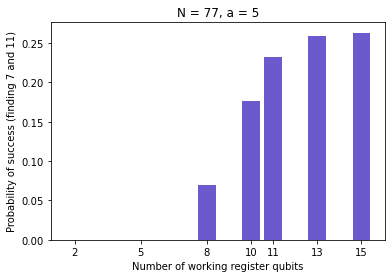

In [715]:
test = 0

vector_prob = []
for t in vector_t:
    n_q = m + t
    prob = get_probabilities(a,N,t,n_q,test)
    vector_prob.append(prob)

plt.bar(vector_t, vector_prob, color='slateblue')
plt.xlabel("Number of working register qubits")
plt.ylabel("Probability of success (finding 7 and 11)")
plt.xticks(vector_t)
#plt.ylim([0, 0.4])
plt.title("N = 77, a = 5")
plt.show()

This plot displays a clear improvement of the performance of the algorithm (in terms of success probability) when increasing the number of working register qubits, as we obtain a higher probability of obtaining both correct factors 7 and 11.

Moreover, we can make a plot of the probability of obtaining at least one of the desired factors (7 or 11) for each value of $t$.

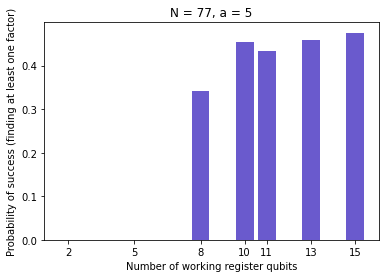

In [716]:
test = 2

vector_prob = []
for t in vector_t:
    n_q = m + t
    prob = get_probabilities(a,N,t,n_q,test)
    vector_prob.append(prob)

plt.bar(vector_t, vector_prob, color='slateblue')
plt.xlabel("Number of working register qubits")
plt.ylabel("Probability of success (finding at least one factor)")
plt.xticks(vector_t)
#plt.ylim([0, 0.4])
plt.title("N = 77, a = 5")
plt.show()

Along with the two previous plots, in this last figure we can appreciate how the probability of finding at least one correct factor is nul when we use few working register qubits, and it generally increases with $t$.

 ### 4.2. Comparison on the effect of different choices of $a$

In this section we study the performance of the algorithm by fixing the size $t$ of the working register and changing the initial random number $a$ that we use to run the algorithm. 

We know that $N^2 \leq 2^t \leq 2N^2$ in order to have at least N different values of $a$ that give the same value of $f(a)$, so we have fixed $t=13$. 

We have tested the factorization of 77 for six different values of $a$ between 3 and 55. The choice of these values is random, only fulfilling the condition that they are coprimes with N, so that $gcd(a,N)=1$. This way, we will obtain a better performance of the order-finding subroutine.


In [763]:
N = 77
t = 13
m = int(np.ceil(np.log2(N))) 
n_q = t + m
vector_a = [3,6,10,17,26,55]

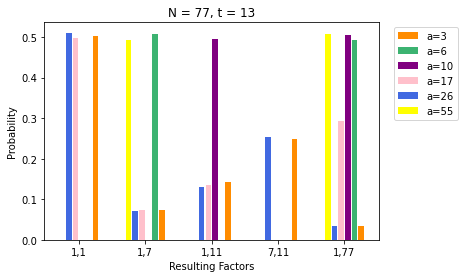

In [764]:
test = 1

vector_prob = []
for a in vector_a:
    prob = get_probabilities(a,N,t,n_q,test)
    vector_prob.append(prob)
    
X = ['1,1','1,7','1,11','7,11','1,77']
a3, a6, a10, a17, a26, a55 = vector_prob[0], vector_prob[1], vector_prob[2], vector_prob[3], vector_prob[4], vector_prob[5]

X_axis = np.arange(len(X))

width_hist = np.linspace(-0.25,0.25,6)
width_bar = 0.5/6.
      
plt.bar(X_axis - width_hist[0], a3, width_bar, label = 'a=3', color = "darkorange")
plt.bar(X_axis - width_hist[1], a6, width_bar, label = 'a=6', color = "mediumseagreen")
plt.bar(X_axis - width_hist[2], a10, width_bar, label = 'a=10', color = "purple")
plt.bar(X_axis - width_hist[3], a17, width_bar, label = 'a=17', color = "pink" )
plt.bar(X_axis - width_hist[4], a26, width_bar, label = 'a=26', color = "royalblue")
plt.bar(X_axis - width_hist[5], a55, width_bar, label = 'a=55', color = "yellow")


plt.xticks(X_axis, X)
plt.xlim
plt.xlabel("Resulting Factors")
plt.ylabel("Probability")
plt.title("N = 77, t = 13")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In this simulation we can appreciate the probabilities of finding each of the possible combinations of guesses after running the algorithm. We can see that, for all the possible values of $a$ that we studied, we find a non-zero probability to find at least one of the correct factors. However, the combination of both correct guesses 7 and 11, is only found by certain $a$ values.

It is important to highlight that we cannot see a specific pattern in this plot in terms of success and the $a$ choice. Finding the value of $a$ that gives the best factorization performance is not easy in practice, since we should choose an $a$ that leads to an adequate period for factorizing $N$, and we assume that we don't know that in advance.

Taking into consideration that we have obtained at least one correct factor of $N$ for all the studied values of $a$, we can say that picking a random $a$ is a good enough approach to obtain satisfactory results when factorizing a number. Moreover, we can draw the conclusion that the number of qubits and the size of $N$ itself, are more determinant factors rather than $a$. 

## 5. Considerations about the measurement requirements and computational cost

When increasing the number $N$ that we want to factorize, more qubits are needed to represent this number (i.e. for $N = 77$ we need $log_2(77) \approx 7$ qubits). The fact that a large number of qubits are requiered has both significant measurement requirements and computational cost.

$\textbf{Measurement requirements:}$ 
The measurements after the Shor's algorithm enable us to extract the period of a function and to determine the non-trivial factors of a number. Nevertheless, these measurements are probabilistic; therefore, many shots are required in order to accumulate enough statistics and be able to find the expected result with high probability. The main concern is that the number of qubits needed to solve the problem with high probability increases in accordance with the number of bits of the number we want to factor; it is known that the number of necessary measurements is proportional to the square of the number of bits of the number $N$, implying that as $N$ grows, the number of requiered measurements increases exponentially. It is clear to see that implementing this algorithm in practice can be a difficult task, because we need to achieve many high-fidelity measurements, the implementation of a large number of coherent qubits and error correction techniques to correct the possible errors introduced by the quantum gates.



$\textbf{Computational cost:}$
Shor's algorithm has a high computational cost, mainly because of the large number of gates that the algorithm uses and because of the computation of the modular exponentiation operation. As the number of qubits we need to represent a number $N$ is $log(N)$, and these are the qubits that perform the modular exponentiation operations, the time complexity of Shor's algorithm is polynomial in $log(N)$. The Shor's algorithm is the one that, up to date, has achieved the most efficient integer factorization in a quantum computer, introducing this problem into the complexity class BQP.

### References

Here some resources that have been of much help for understanding the Shor's Algorithm functioning:

[1] Qiskit Textbook: 
https://qiskit.org/textbook/ch-algorithms/shor.html


[2] "Quantum Computation and Quantum Information" book, by Nielsen and Chuang: Nielsen, Michael A., and Isaac Chuang. "Quantum computation and quantum information." (2002): 558-559.


[3] "Study of Shor’s factoring algorithm using IBMs quantum computers", Final Physics Degree Thesis (UB) by Berta Cases: http://diposit.ub.edu/dspace/bitstream/2445/180765/1/CASAS%20I%20FONT%20BERTA_4253624_assignsubmission_file_TFG-Casas-Font-Berta.pdf

[4] github.com/quantummasterbarcelonacode/QuantumComputation/tree/main/Factoring